# Imports necessários


In [1]:
import pandas as pd
import numpy as np
import graphviz as gv

# Import dos dados

In [2]:
# features receitas
dados_receitas = pd.read_csv('03_dados_carga/arquivos_para_carga/dados_receitas.csv', sep=';')
dados_receitas.head()

,COD_RECEITA,DATA,COD_CONTRIBUINTE,VALOR_ARRECADADO,FONTE_DADOS
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,prefeitura municipal
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,prefeitura municipal
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,prefeitura municipal
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,prefeitura municipal
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,prefeitura municipal


In [3]:
# features despesas
dados_despesas = pd.read_csv('03_dados_carga/arquivos_para_carga/novos_dados_despesas.csv', sep=';')
dados_despesas.head()

,DATA_FATO,COD_DESPESA,CREDOR,NUM_DOCUMENTO,FONTE_RECURSO,ORGAO_INTERNO,ORGAO_VINCULADO,ELEMENTO,SUBELEMENTO,FUNCAO,SUBFUNCAO,NATUREZA,VALOR_FIXADO,VALOR_EMPENHADO,VALOR_LIQUIDADO,VALOR_PAGO,SALDO
0,2013-12-31,3300,alianca do brasil seguros s a,01.378.407/0001-10,recursos ordinarios,secretaria municipal de infra estrutura,prefeitura municipal,39.0,2044.0,4,122,3,2911694.0,5120.0,5120.0,0.0,5120.0
1,2013-12-31,3299,ademir santana da silva,***.893.004-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,6950.0,6950.0,0.0,6950.0
2,2013-12-31,3298,olindina glicia gomes pereira,***.859.974-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,800.0,800.0,0.0,800.0
3,2013-12-31,3297,taise kelly cezario de souza,***.039.644-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,400.0,400.0,0.0,400.0
4,2013-12-31,3296,otavio leoncio pereira,***.396.364-**,recursos ordinarios,secretaria municipal de educacao,prefeitura municipal,36.0,2029.0,13,392,3,107000.0,600.0,600.0,0.0,600.0


# Árvore de decisão

## Imports necessários

In [4]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Implementação do algoritmo

## Tratamento dos dados

In [5]:
# dicionário para mapear valores únicos
valor_para_numero = {}
proximo_numero = [1] # O próximo número a ser atribuído

# Função para atribuir números únicos aos valores
def atribuir_numero(valor):
    if valor in valor_para_numero:
        return valor_para_numero[valor]
    else:
        valor_para_numero[valor] = proximo_numero[0]
        proximo_numero[0] += 1
        return valor_para_numero[valor]

dados_receitas['COD_CONTRIBUINTE_INTEIRO'] = dados_receitas['COD_CONTRIBUINTE'].apply(atribuir_numero)
dados_despesas['COD_CONTRIBUINTE_INTEIRO'] = dados_despesas['NUM_DOCUMENTO'].apply(atribuir_numero)
dados_receitas['COD_FONTE_DADOS'] = dados_receitas['FONTE_DADOS'].apply(atribuir_numero)
dados_despesas['COD_FONTE_DADOS'] = dados_despesas['ORGAO_VINCULADO'].apply(atribuir_numero)
dados_despesas['COD_FONTE_DADOS_INTERNO'] = dados_despesas['ORGAO_INTERNO'].apply(atribuir_numero)
dados_despesas['COD_FONTE_RECURSO'] = dados_despesas['FONTE_RECURSO'].apply(atribuir_numero)
dados_despesas['COD_CREDOR'] = dados_despesas['CREDOR'].apply(atribuir_numero)

In [6]:
# Converter a coluna 'DATA' para o tipo datetime
dados_receitas['DATA'] = pd.to_datetime(dados_receitas['DATA'])

# Extrair o ano, mês e dia da coluna 'DATA' como novas features
dados_receitas['ANO'] = dados_receitas['DATA'].dt.year
dados_receitas['MES'] = dados_receitas['DATA'].dt.month
dados_receitas['DIA'] = dados_receitas['DATA'].dt.day

# Converter a coluna 'DATA' para o tipo datetime
dados_despesas['DATA_FATO'] = pd.to_datetime(dados_despesas['DATA_FATO'])

# Extrair o ano, mês e dia da coluna 'DATA' como novas features
dados_despesas['ANO'] = dados_despesas['DATA_FATO'].dt.year
dados_despesas['MES'] = dados_despesas['DATA_FATO'].dt.month
dados_despesas['DIA'] = dados_despesas['DATA_FATO'].dt.day

## 1. Classificação e regressão de receitas: 
<p>Podemos usar árvores de decisões para prever os valores arrecadados com base em outras variáveis, como a data, o código da receita ou a sua fonte.</p> 
<p>Isso pode ser útil para prever receitas futuras com base em padrões passados.</p>
<p>Utilizaremos uma porcentagem dos dados contidos no dataframe das receitas.</p>

### Remoção dos outliers

In [7]:
dados_receitas.describe().round(2)

,COD_RECEITA,DATA,VALOR_ARRECADADO,COD_CONTRIBUINTE_INTEIRO,COD_FONTE_DADOS,ANO,MES,DIA
count,1.022930e+05,102293,102293.00,102293.00,102293.00,102293.00,102293.00,102293.00
mean,1.256925e+09,2017-11-11 13:19:10.635918336,12522.46,351.08,7667.13,2017.34,6.70,17.50
min,1.112500e+08,2013-01-02 00:00:00,-2489288.55,1.00,7667.00,2013.00,1.00,1.00
25%,1.113034e+09,2015-07-16 00:00:00,51.23,65.00,7667.00,2015.00,4.00,10.00
50%,1.121250e+09,2017-10-13 00:00:00,240.60,124.00,7667.00,2017.00,7.00,18.00
75%,1.325000e+09,2020-02-05 00:00:00,1579.25,450.00,7667.00,2020.00,10.00,27.00
max,9.728013e+09,2022-12-30 00:00:00,4674330.00,1566.00,7669.00,2022.00,12.00,31.00
std,1.162115e+09,NaN,89618.73,461.96,0.45,2.71,3.47,9.53


<Axes: title={'center': 'VALOR_ARRECADADO'}, xlabel='[ANO]'>

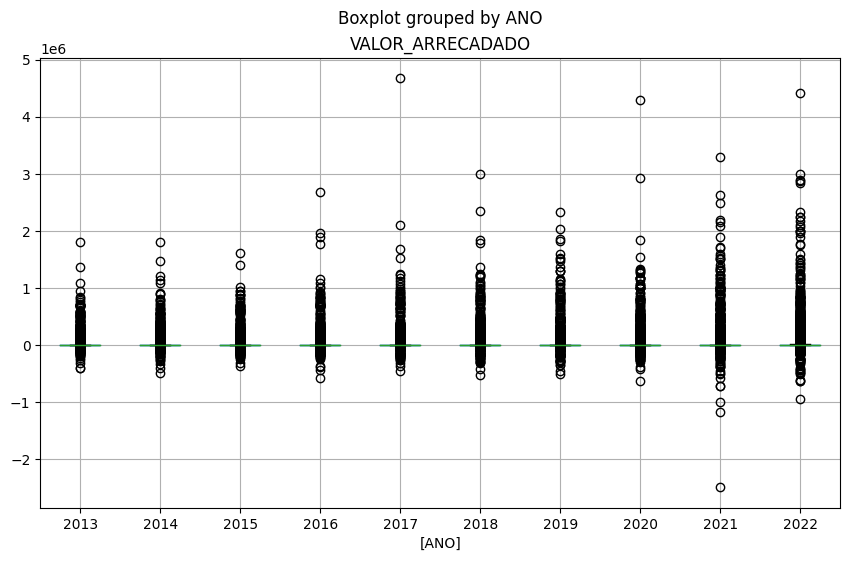

In [8]:
dados_box_plot = dados_receitas[['ANO', 'VALOR_ARRECADADO']]
dados_box_plot.boxplot(by='ANO', figsize=(10, 6))

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


<Axes: title={'center': 'VALOR_ARRECADADO'}, xlabel='[ANO]'>

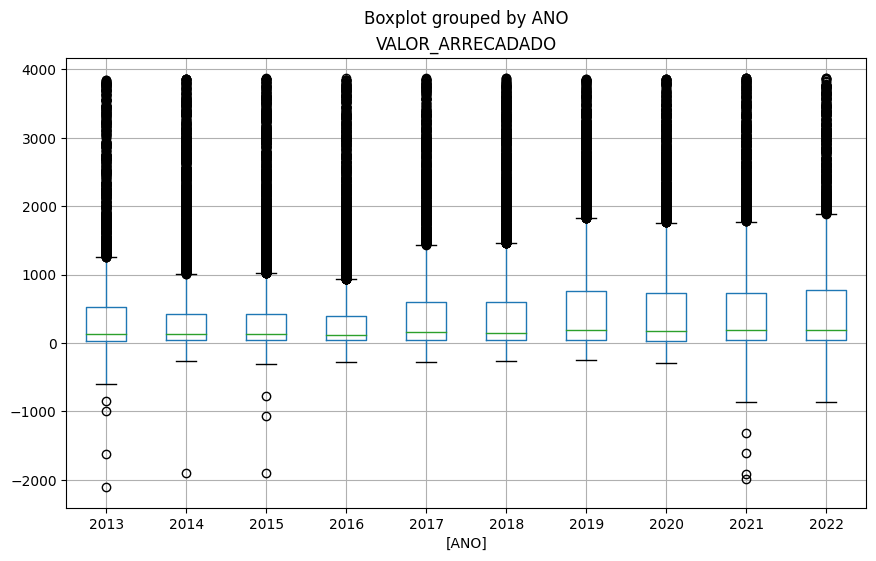

In [9]:
# aplicação de IQR - interquartile range
Q1 = dados_receitas['VALOR_ARRECADADO'].quantile(0.25)
Q3 = dados_receitas['VALOR_ARRECADADO'].quantile(0.75)
IQR = Q3 - Q1
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print(f'Limite inferior: {limite_inferior}')
print(f'Limite superior: {limite_superior}')

df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]
df_sem_outliers = df_sem_outliers[['ANO', 'VALOR_ARRECADADO']]
print(f'Quantidade de registros sem outliers: {df_sem_outliers.shape[0]}')
df_sem_outliers.boxplot(by='ANO', figsize=(10, 6))

In [10]:
df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]

In [11]:
# Coluna pela qual você deseja amostrar proporcionalmente
coluna_amostragem = 'ANO'

# Porcentagem de amostras desejadas)
porcentagem_amostra = 0.05

# Divida o DataFrame em grupos com base na coluna de amostragem
grupos = df_sem_outliers.groupby(coluna_amostragem, group_keys=False, sort=False)

# Inicialize listas para armazenar os DataFrames de amostra e de não amostra
amostras = []
nao_amostras = []

# Para cada grupo, aplique o método sample com a porcentagem desejada
for nome_grupo, grupo in grupos:
    grupo_amostra = grupo.sample(frac=porcentagem_amostra)
    
    # Adicione o grupo de amostra à lista de amostras
    amostras.append(grupo_amostra)
    
    # Adicione o grupo de não amostra à lista de não amostras
    grupo_nao_amostra = grupo.drop(grupo_amostra.index)
    nao_amostras.append(grupo_nao_amostra)

# Crie um novo DataFrame contendo todas as amostras
df_amostrado = pd.concat(amostras)

# Crie um novo DataFrame contendo todos os dados que não entraram no sample
df_nao_amostrado = pd.concat(nao_amostras)

### Implementação das árvores

In [12]:
# Definir as features (recursos) e o alvo (target)
X = ['ANO', 'VALOR_ARRECADADO']
y = 'FONTE_DADOS'

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Criar o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinar o classificador com os dados de treinamento
clf.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = clf.predict(X_test)

# Obter o número de nós da árvore
num_nodes = clf.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliar a acurácia do modelo
accuracy = (accuracy_score(y_test, y_pred) * 100)
print(f'Acurácia: {accuracy:.2f}%')

# Exibir o relatório de classificação
report = classification_report(y_test, y_pred)
print('Relatório de Classificação:\n', report)

Tamanho da árvore: 875 nós.
Acurácia: 87.23%
Relatório de Classificação:
                                                precision    recall  f1-score   support

instituto de previdencia e assistencia social       0.23      0.24      0.23        21
                         prefeitura municipal       0.93      0.93      0.93       774
                                      sctrans       0.14      0.14      0.14        43

                                     accuracy                           0.87       838
                                    macro avg       0.43      0.44      0.43       838
                                 weighted avg       0.87      0.87      0.87       838



In [13]:
# plt.figure(figsize=(50,70))  # Ajuste o tamanho conforme necessário

# # Converta o Index para uma lista de nomes de colunas
# feature_names = list(df_amostrado[X].columns)

# # Converta os valores únicos de y para uma lista
# class_names = list(df_amostrado[y].unique())

# plot_tree(clf, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
# plt.show()

In [14]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_amostrado[X].columns,
                                class_names=df_amostrado[y].unique(),
                                filled=True, rounded=True,
                                special_characters=True)
graph = gv.Source(dot_data)
graph.render("arvore_decisao_receitas_fonte_dados")

'arvore_decisao_receitas_fonte_dados.pdf'

<p>Combinação com porcentagem de acurácia baixíssima, 14%.</p>

In [15]:
# # Definir as features (recursos) e o alvo (target)
# X = ['COD_FONTE_DADOS', 'VALOR_ARRECADADO']
# y = 'ANO'

# # Dividir os dados em conjunto de treinamento e teste
# X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# # Criar o classificador de árvore de decisão
# clf = DecisionTreeClassifier()

# # Treinar o classificador com os dados de treinamento
# clf.fit(X_train, y_train)

# # Fazer previsões com os dados de teste
# y_pred = clf.predict(X_test)

# # Obter o número de nós da árvore
# num_nodes = clf.tree_.node_count
# print(f"Tamanho da árvore: {num_nodes} nós.")

# # Avaliar a acurácia do modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Acurácia: {accuracy:.2f}%')

# # Exibir o relatório de classificação
# report = classification_report(y_test, y_pred)
# print('Relatório de Classificação:\n', report)

In [16]:
# dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=df_amostrado[X].columns,
#                                 class_names=list(map(str, df_amostrado[y].unique())),
#                                 filled=True, rounded=True,
#                                 special_characters=True)
# graph = gv.Source(dot_data)
# graph.render("arvore_decisao_ano_dados")

In [17]:
# Definir as features (recursos) e o alvo (target)
X = ['VALOR_ARRECADADO', 'COD_RECEITA', 'ANO']
y = 'COD_CONTRIBUINTE_INTEIRO'

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Criar o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinar o classificador com os dados de treinamento
clf.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = clf.predict(X_test)

# Obter o número de nós da árvore
num_nodes = clf.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliar a acurácia do modelo
accuracy = (accuracy_score(y_test, y_pred) * 100)
print(f'Acurácia: {accuracy:.2f}%')

# Exibir o relatório de classificação
report = classification_report(y_test, y_pred)
print('Relatório de Classificação:\n', report)

Tamanho da árvore: 3015 nós.
Acurácia: 56.68%
Relatório de Classificação:
               precision    recall  f1-score   support

           1       0.68      0.71      0.69        35
           2       0.73      0.64      0.68        87
           3       0.91      0.88      0.90        60
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.67      0.50      0.57         4
          11       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         0
          34       0.00      0.00      0.00         2
          37       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          41       1.00      1.00      1.00         2
          50       0.00      0.00      0.00         0
      

c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [18]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_amostrado[X].columns,
                                class_names=list(map(str, df_amostrado[y].unique())),
                                filled=True, rounded=True,
                                special_characters=True)
graph = gv.Source(dot_data)
graph.render("arvore_decisao_receitas_contribuintes_tipo_dados")

'arvore_decisao_receitas_contribuintes_tipo_dados.pdf'

In [19]:
# Definir as features (recursos) e o alvo (target)
X = ['VALOR_ARRECADADO', 'COD_RECEITA', 'ANO']
y = 'COD_FONTE_DADOS'

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Criar o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinar o classificador com os dados de treinamento
clf.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = clf.predict(X_test)

# Obter o número de nós da árvore
num_nodes = clf.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliar a acurácia do modelo
accuracy = (accuracy_score(y_test, y_pred) * 100)
print(f'Acurácia: {accuracy:.2f}%')

# Exibir o relatório de classificação
report = classification_report(y_test, y_pred)
print('Relatório de Classificação:\n', report)

Tamanho da árvore: 195 nós.
Acurácia: 97.02%
Relatório de Classificação:
               precision    recall  f1-score   support

        7667       0.98      0.99      0.98       774
        7668       0.68      0.71      0.70        21
        7669       0.90      0.81      0.85        43

    accuracy                           0.97       838
   macro avg       0.85      0.84      0.85       838
weighted avg       0.97      0.97      0.97       838



In [20]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_amostrado[X].columns,
                                class_names=list(map(str, df_amostrado[y].unique())),
                                filled=True, rounded=True,
                                special_characters=True)
graph = gv.Source(dot_data)
graph.render("arvore_decisao_receitas_fonte_tipo_dados")

'arvore_decisao_receitas_fonte_tipo_dados.pdf'

<p>Modelo com acurácia baixíssima, 27%</p>

In [21]:
# # Definir as features (recursos) e o alvo (target)
# X = ['VALOR_ARRECADADO','ANO']
# y = 'COD_RECEITA'

# # Dividir os dados em conjunto de treinamento e teste
# X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# # Criar o classificador de árvore de decisão
# clf = DecisionTreeClassifier()

# # Treinar o classificador com os dados de treinamento
# clf.fit(X_train, y_train)

# # Fazer previsões com os dados de teste
# y_pred = clf.predict(X_test)

# # Obter o número de nós da árvore
# num_nodes = clf.tree_.node_count
# print(f"Tamanho da árvore: {num_nodes} nós.")

# # Avaliar a acurácia do modelo
# accuracy = (accuracy_score(y_test, y_pred) * 100)
# print(f'Acurácia: {accuracy:.2f}%')

# # Exibir o relatório de classificação
# report = classification_report(y_test, y_pred)
# print('Relatório de Classificação:\n', report)

In [22]:
# Definir as features (recursos) e o alvo (target)
X = ['COD_CONTRIBUINTE_INTEIRO']
y = 'VALOR_ARRECADADO'

# Supondo que X contenha as características relevantes e y seja o valor arrecadado
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Crie e treine um modelo de regressão de árvore de decisão
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Faça previsões
y_pred = regressor.predict(X_test)

# Obter o número de nós da árvore
num_nodes = regressor.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

Tamanho da árvore: 761 nós.
Erro Quadrático Médio (MSE): 556366.54
Erro Absoluto Médio (MAE): 466.92
Coeficiente de Determinação (R²): 0.15


In [23]:
# Definir as features (recursos) e o alvo (target)
X = ['COD_CONTRIBUINTE_INTEIRO']
y = 'VALOR_ARRECADADO'

# Supondo que X contenha as características relevantes e y seja o valor arrecadado
X_train, X_test, y_train, y_test = train_test_split(df_nao_amostrado[X], df_nao_amostrado[y], test_size=0.2, random_state=42)

# Faça previsões
y_pred = regressor.predict(X_test)

# Obter o número de nós da árvore
num_nodes = regressor.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

Tamanho da árvore: 761 nós.
Erro Quadrático Médio (MSE): 528324.47
Erro Absoluto Médio (MAE): 465.38
Coeficiente de Determinação (R²): 0.10


In [24]:
# # Plot the results
# plt.figure()
# plt.scatter(df_amostrado[X], df_amostrado[y], s=20, edgecolor="black", c="darkorange", label="data")
# plt.plot(X_test, y_pred_regressor_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
# plt.plot(X_test, y_pred_regressor_2, color="yellowgreen", label="max_depth=5", linewidth=2)
# plt.xlabel("data")
# plt.ylabel("target")
# plt.title("Decision Tree Regression")
# plt.legend()
# plt.show()

In [25]:
names = df_amostrado[X].columns.tolist()

dot_data = tree.export_graphviz(regressor, out_file=None,
                                feature_names=names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = gv.Source(dot_data)
graph.render("arvore_regressiva_receitas_valor_dados")

'arvore_regressiva_receitas_valor_dados.pdf'

## 2. Classificação e regressão das despesas

### Remoção dos outliers

In [26]:
dados_despesas.describe().round(2)

,DATA_FATO,COD_DESPESA,ELEMENTO,SUBELEMENTO,FUNCAO,SUBFUNCAO,NATUREZA,VALOR_FIXADO,VALOR_EMPENHADO,VALOR_LIQUIDADO,VALOR_PAGO,SALDO,COD_CONTRIBUINTE_INTEIRO,COD_FONTE_DADOS,COD_FONTE_DADOS_INTERNO,COD_FONTE_RECURSO,COD_CREDOR,ANO,MES,DIA
count,86856,86856.00,86841.00,86841.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00,86856.00
mean,2018-03-13 02:58:49.372754944,4135.32,76654.96,2996.75,9.00,209.05,4.38,336023.96,14960.52,14503.51,13217.86,1501.01,3288.90,7667.94,7677.28,7717.46,10435.10,2017.65,6.99,18.14
min,2013-01-02 00:00:00,1.00,1.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,-396163.17,1567.00,7667.00,7670.00,7694.00,7750.00,2013.00,1.00,1.00
25%,2015-08-20 00:00:00,969.00,30.00,2016.00,4.00,122.00,3.00,1000.00,250.00,240.00,150.00,0.00,1635.00,7667.00,7671.00,7694.00,7910.00,2015.00,4.00,10.00
50%,2018-03-26 00:00:00,2896.00,39.00,2059.00,8.00,244.00,3.00,50000.00,991.90,880.00,614.47,0.00,2550.00,7667.00,7676.00,7711.00,9203.00,2018.00,7.00,19.00
75%,2020-10-15 00:00:00,5336.00,93.00,2083.00,12.00,302.00,3.00,200000.00,5253.98,4995.00,3805.38,0.00,4602.00,7667.00,7682.00,7735.00,12627.00,2020.00,10.00,28.00
max,2022-12-30 00:00:00,40512.00,469171.00,9999.00,28.00,845.00,10.00,14400000.00,2795000.00,2795000.00,2795000.00,1639155.73,7666.00,7674.00,7693.00,7749.00,16993.00,2022.00,12.00,31.00
std,NaN,5984.50,142368.01,2637.53,7.11,151.91,3.11,1010836.57,71586.43,70571.36,68096.06,19964.89,1955.69,1.77,6.78,20.81,2714.43,2.90,3.32,9.64


<Axes: title={'center': 'VALOR_PAGO'}, xlabel='[ANO]'>

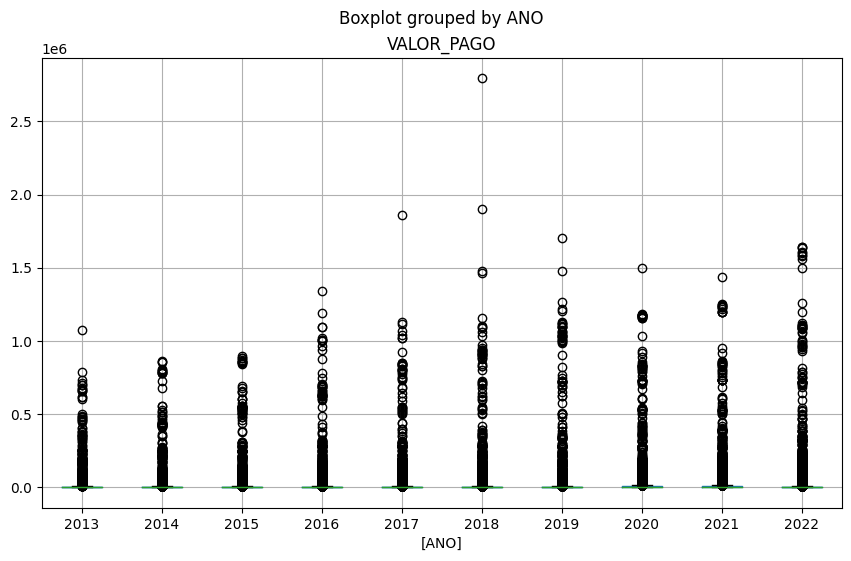

In [27]:
dados_box_plot = dados_despesas[['ANO', 'VALOR_PAGO']]
dados_box_plot.boxplot(by='ANO', figsize=(10, 6))

Q1: 150.0
Q3: 3805.3775
IQR: 3655.3775
Limite inferior: -5333.06625
Limite superior: 9288.44375
Quantidade de registros sem outliers: 72505


<Axes: title={'center': 'VALOR_PAGO'}, xlabel='[ANO]'>

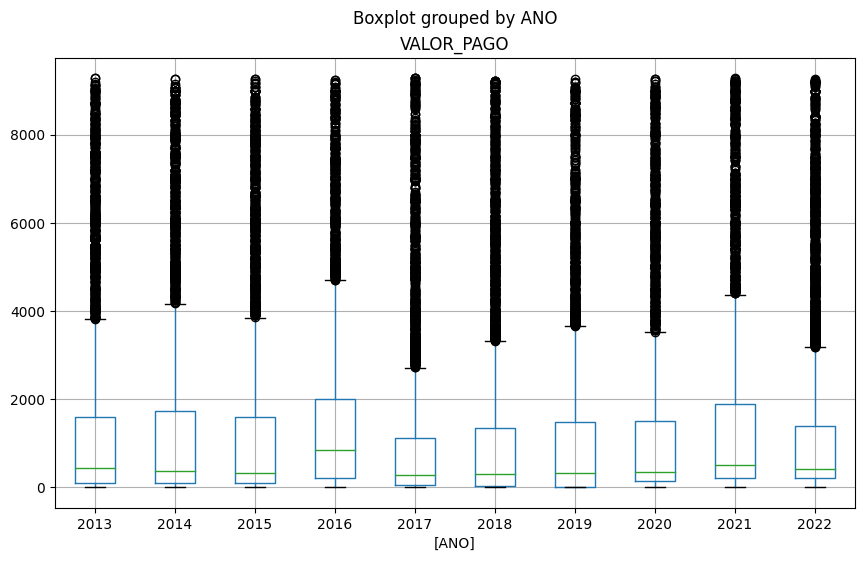

In [28]:
# aplicação de IQR - interquartile range
Q1 = dados_despesas['VALOR_PAGO'].quantile(0.25)
Q3 = dados_despesas['VALOR_PAGO'].quantile(0.75)
IQR = Q3 - Q1
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print(f'Limite inferior: {limite_inferior}')
print(f'Limite superior: {limite_superior}')

df_sem_outliers = dados_despesas[(dados_despesas['VALOR_PAGO'] >= limite_inferior) & (dados_despesas['VALOR_PAGO'] <= limite_superior)]
df_sem_outliers = df_sem_outliers[['ANO', 'VALOR_PAGO']]
print(f'Quantidade de registros sem outliers: {df_sem_outliers.shape[0]}')
df_sem_outliers.boxplot(by='ANO', figsize=(10, 6))

In [29]:
df_sem_outliers = dados_despesas[(dados_despesas['VALOR_PAGO'] >= limite_inferior) & (dados_despesas['VALOR_PAGO'] <= limite_superior)]

In [30]:
# Coluna pela qual você deseja amostrar proporcionalmente
coluna_amostragem = 'ANO'

# Porcentagem de amostras desejadas)
porcentagem_amostra = 0.05

# Divida o DataFrame em grupos com base na coluna de amostragem
grupos = df_sem_outliers.groupby(coluna_amostragem, group_keys=False, sort=False)

# Inicialize listas para armazenar os DataFrames de amostra e de não amostra
amostras = []
nao_amostras = []

# Para cada grupo, aplique o método sample com a porcentagem desejada
for nome_grupo, grupo in grupos:
    grupo_amostra = grupo.sample(frac=porcentagem_amostra)
    
    # Adicione o grupo de amostra à lista de amostras
    amostras.append(grupo_amostra)
    
    # Adicione o grupo de não amostra à lista de não amostras
    grupo_nao_amostra = grupo.drop(grupo_amostra.index)
    nao_amostras.append(grupo_nao_amostra)

# Crie um novo DataFrame contendo todas as amostras
df_amostrado = pd.concat(amostras)

# Crie um novo DataFrame contendo todos os dados que não entraram no sample
df_nao_amostrado = pd.concat(nao_amostras)

In [31]:
df_amostrado

,DATA_FATO,COD_DESPESA,CREDOR,NUM_DOCUMENTO,FONTE_RECURSO,ORGAO_INTERNO,ORGAO_VINCULADO,ELEMENTO,SUBELEMENTO,FUNCAO,...,VALOR_PAGO,SALDO,COD_CONTRIBUINTE_INTEIRO,COD_FONTE_DADOS,COD_FONTE_DADOS_INTERNO,COD_FONTE_RECURSO,COD_CREDOR,ANO,MES,DIA
6097,2013-06-21,307,cagepa comp de agua e esgoto da paraiba,09.123.654/0001-87,recursos ordinarios,fundo municipal de assistencia social,fundo municipal de assistencia social,39.0,2160.0,8,...,91.36,0.0,1649,7671,7671,7694,8501,2013,6,21
6436,2013-10-14,236,francisco das chagas pedrosa,***.078.504-**,recursos ordinarios,superintendencia cajazeirense de transito,superintendencia cajazeirense de transito,36.0,2061.0,4,...,265.00,0.0,2559,7672,7672,7694,8815,2013,10,14
2898,2013-07-12,1510,assoc das antigas alunas doroteias,09.247.065/0001-00,receita de impostos e transferencias de impos...,secretaria municipal de educacao,prefeitura municipal,39.0,2033.0,12,...,1860.00,0.0,1587,7667,7676,7695,7770,2013,7,12
6528,2013-02-25,218,severina de lima bertoldo viana,***.681.854-**,receita de impostos e transferencias de impos...,secretaria municipal de educacao,prefeitura municipal,14.0,2033.0,12,...,500.00,0.0,2414,7667,7676,7695,8653,2013,2,25
5136,2013-04-24,631,c mendes feitosa,24.215.436/0001-66,recursos ordinarios,secretaria municipal de administracao,prefeitura municipal,30.0,2010.0,4,...,5088.55,0.0,1629,7667,7677,7694,7814,2013,4,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80431,2022-06-21,3368,ademir santana da silva 300 488,NaN,sem informacoes,secretaria municipal de cultura e turismo,prefeitura municipal,339018.0,9900.0,1,...,800.00,0.0,7377,7667,7690,7749,14094,2022,6,21
86786,2022-12-23,2208,sec de saude centro de reab audit efetivos,11.902.878/0001-39,sem informacoes,fundo municipal de saude,fundo municipal de saude,319011.0,9601.0,1,...,0.00,0.0,1724,7670,7670,7749,14312,2022,12,23
83119,2022-10-10,6088,adelba da silva alves 438 440,NaN,sem informacoes,secretaria municipal de educacao,prefeitura municipal,339036.0,2299.0,1,...,600.00,0.0,7377,7667,7676,7749,14074,2022,10,10
81557,2022-08-02,4516,francisca francinete felix 708 453,NaN,sem informacoes,procuradoria geral do municipio,prefeitura municipal,339091.0,9905.0,1,...,0.00,0.0,7377,7667,7684,7749,16433,2022,8,2


In [37]:
# Definir as features (recursos) e o alvo (target)
X = ['VALOR_PAGO', 'ANO']
y = 'COD_FONTE_RECURSO'

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Criar o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinar o classificador com os dados de treinamento
clf.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = clf.predict(X_test)

# Obter o número de nós da árvore
num_nodes = clf.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliar a acurácia do modelo
accuracy = (accuracy_score(y_test, y_pred) * 100)
print(f'Acurácia: {accuracy:.2f}%')

# Exibir o relatório de classificação
report = classification_report(y_test, y_pred)
print('Relatório de Classificação:\n', report)

Tamanho da árvore: 1961 nós.
Acurácia: 55.45%
Relatório de Classificação:
               precision    recall  f1-score   support

        7694       0.56      0.71      0.63       217
        7695       0.00      0.00      0.00         3
        7699       0.00      0.00      0.00         0
        7701       0.20      0.12      0.15        16
        7702       0.38      0.21      0.27        14
        7703       0.00      0.00      0.00         1
        7705       0.00      0.00      0.00         6
        7706       0.00      0.00      0.00         1
        7707       0.36      0.40      0.38        10
        7708       0.15      0.20      0.17        15
        7709       0.38      0.41      0.39        29
        7710       0.57      0.74      0.64        70
        7711       0.33      0.18      0.24        11
        7712       0.00      0.00      0.00         9
        7713       0.00      0.00      0.00         9
        7714       0.00      0.00      0.00         2
      

c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [38]:
# Definir as features (recursos) e o alvo (target)
X = ['VALOR_PAGO', 'ANO']
y = 'ORGAO_INTERNO'

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Criar o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinar o classificador com os dados de treinamento
clf.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = clf.predict(X_test)

# Obter o número de nós da árvore
num_nodes = clf.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliar a acurácia do modelo
accuracy = (accuracy_score(y_test, y_pred) * 100)
print(f'Acurácia: {accuracy:.2f}%')

# Exibir o relatório de classificação
report = classification_report(y_test, y_pred)
print('Relatório de Classificação:\n', report)

Tamanho da árvore: 2783 nós.
Acurácia: 32.28%
Relatório de Classificação:
                                                                                       precision    recall  f1-score   support

                                             Secretaria Municipal de Controle Social       0.17      0.20      0.18         5
                                                                    camara municipal       0.00      0.00      0.00         5
                                               fundo municipal de assistencia social       0.12      0.09      0.10        57
                                                            fundo municipal de saude       0.32      0.50      0.39       145
                      instituto de previdencia e assistencia municipal de cajazeiras       0.25      0.14      0.18        37
                                                     procuradoria geral do municipio       0.00      0.00      0.00        10
                                        se

In [39]:
# Definir as features (recursos) e o alvo (target)
X = ['VALOR_PAGO', 'ANO']
y = 'ORGAO_VINCULADO'

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Criar o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinar o classificador com os dados de treinamento
clf.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = clf.predict(X_test)

# Obter o número de nós da árvore
num_nodes = clf.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliar a acurácia do modelo
accuracy = (accuracy_score(y_test, y_pred) * 100)
print(f'Acurácia: {accuracy:.2f}%')

# Exibir o relatório de classificação
report = classification_report(y_test, y_pred)
print('Relatório de Classificação:\n', report)

Tamanho da árvore: 1349 nós.
Acurácia: 71.86%
Relatório de Classificação:
                                                                 precision    recall  f1-score   support

                                              camara municipal       0.00      0.00      0.00         5
                         fundo municipal de assistencia social       0.21      0.10      0.14        29
                                      fundo municipal de saude       0.40      0.40      0.40        96
instituto de previdencia e assistencia municipal de cajazeiras       0.25      0.11      0.15        18
                                          prefeitura municipal       0.82      0.86      0.84       550
                     superintendencia cajazeirense de transito       0.21      0.22      0.21        27

                                                      accuracy                           0.72       725
                                                     macro avg       0.32      0.28      0.

In [33]:
# Definir as features (recursos) e o alvo (target)
X = ['COD_DESPESA', 'COD_FONTE_RECURSO', 'COD_FONTE_DADOS_INTERNO', 'ANO']
y = 'VALOR_PAGO'

# Supondo que X contenha as características relevantes e y seja o valor arrecadado
X_train, X_test, y_train, y_test = train_test_split(df_amostrado[X], df_amostrado[y], test_size=0.2, random_state=42)

# Crie e treine um modelo de regressão de árvore de decisão
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Faça previsões
y_pred = regressor.predict(X_test)

# Obter o número de nós da árvore
num_nodes = regressor.tree_.node_count
print(f"Tamanho da árvore: {num_nodes} nós.")

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

Tamanho da árvore: 5049 nós.
Erro Quadrático Médio (MSE): 5987242.49
Erro Absoluto Médio (MAE): 1450.82
Coeficiente de Determinação (R²): -0.78


In [ ]:
import tensorflow as tf

# Criando um modelo sequencial
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(output_dim, activation='softmax')
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

predictions = model.predict(X_test)

predictions

NameError: name 'input_dim' is not defined